Generate 200 terms and run it on LO, RI, Rand as starting point.
Then run a new reward mod env with different configurations, look at results.
Reward distributions (test_1): 1:10, 1:11
Reward distributions (test_2): 1:1, 1:4, 1:16, 1:32, 1:64, 1:128

In [1]:
import random
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions
from deap import tools, base, creator
import seaborn as sns

sys.path.append("../")
from calculus.term import *
from calculus.strategy import *
from calculus.generation import *
from calculus.generation_threading import *

from calculus_utils.drawing import *
from calculus_utils.algorithms import *
from calculus_utils.outliers_cleaning import clear_arr

from vd_env.lambda_env import LambdaEnv
from vd_env.run_greedy_policy import run_greedy_policy
from vd_env.run_e_greedy_policy import run_e_greedy_policy

In [2]:
RANDOM_AVERAGE_COUNT = 20

terms, stepsLO = gen_filtered_lambda_terms_v2(count_terms=200)
stepsRI = [term.normalize(RightmostInnermostStrategy())[1] for term in tqdm(terms)]
stepsRand = [
    sum(term.normalize(RandomStrategy())[1] for i in range(RANDOM_AVERAGE_COUNT))
    / RANDOM_AVERAGE_COUNT
    for term in tqdm(terms)
]

100%|██████████| 200/200 [00:15<00:00, 12.59it/s]


In [3]:
print(f"Generated LO normalizable terms: {len(terms)}\n")
print(f"LO steps: {stepsLO}\n")
print(f"RI steps: {stepsRI}\n")
print(f"Rand steps: {stepsRand}\n")
print(f"LO max: {max(stepsLO)}")
print(f"RI max: {max(stepsRI)}")
print(f"Rand max: {max(stepsRand)}")

Generated LO normalizable terms: 200

LO steps: [11, 1, 3, 7, 1, 3, 8, 1, 3, 5, 18, 6, 8, 4, 14, 8, 5, 1, 5, 3, 5, 10, 2, 14, 3, 9, 4, 4, 2, 11, 1, 6, 14, 3, 3, 3, 22, 5, 8, 12, 5, 13, 4, 1, 19, 12, 21, 2, 10, 1, 19, 3, 3, 11, 6, 1, 4, 19, 14, 5, 6, 4, 2, 1, 8, 29, 3, 3, 3, 9, 18, 2, 5, 10, 17, 6, 4, 6, 6, 3, 9, 8, 5, 6, 7, 5, 10, 5, 3, 13, 8, 4, 31, 71, 6, 4, 21, 135, 38, 5, 4, 11, 4, 8, 5, 7, 5, 8, 9, 5, 3, 2, 4, 2, 7, 4, 6, 29, 5, 3, 4, 2, 1, 2, 21, 8, 3, 5, 8, 9, 5, 1, 14, 7, 21, 3, 3, 4, 1, 9, 3, 5, 4, 35, 3, 17, 1, 5, 1, 1, 6, 8, 2, 3, 35, 10, 30, 7, 10, 5, 2, 1, 2, 6, 3, 5, 16, 9, 2, 4, 8, 5, 8, 3, 4, 21, 1, 1, 5, 18, 3, 6, 2, 5, 4, 18, 2, 28, 4, 18, 5, 7, 1, 9, 7, 9, 4, 9, 3, 3]

RI steps: [11, 1, 3, 8, 8, 5, 12, 3, 5, 7, 18, 6, 8, 5, 18, 9, 7, 1, 5, 3, 5, 11, 4, 10, 8, 11, 7, 4, 5, 8, 6, 8, 14, 7, 3, 7, 17, 16, 8, 9, 6, 13, 4, 6, 16, 13, 21, 8, 15, 8, 15, 8, 8, 11, 11, 15, 7, 18, 14, 16, 14, 4, 5, 2, 6, 17, 4, 7, 7, 12, 14, 2, 5, 8, 7, 6, 4, 10, 5, 9, 6, 9, 5, 8, 9, 5, 10, 7, 

In [4]:
max_count_steps_rlenv = 100
strategies_env = [LeftmostOutermostStrategy(), RightmostInnermostStrategy()]

explore_actions = 100
epsilon = 0.1

In [5]:
def experiment(reward_values=(-1, 0)):
    env = LambdaEnv(
        strategies=strategies_env,
        lambda_terms=terms,
        max_step_term=max_count_steps_rlenv,
        count_terms=len(terms),
        reward_values=(-1, 0),
    )

    _, steps_env = run_e_greedy_policy(
        environment=env,
        exploration=explore_actions,
        max_term_reward=max_count_steps_rlenv,
        epsilon=epsilon,
        deterministic=False,
        is_action_based=True,
        return_steps=True,
    )
    print(f"Steps eg orig: {steps_env}")
    wh_orig = np.array(env.get_weights_history())

    comp_data = {
        "E-greedy n-d a-b": (clear_arr(steps_env), "-"),
        "LO": (clear_arr(stepsLO), "-"),
        "RI": (clear_arr(stepsRI), "-"),
        "Rand": (clear_arr(stepsRand), "-"),
    }
    draw_cumulative_avg_comparison(
        comp_data, title=f"Clear avgcum, reward {reward_values}"
    )

    comp_data = {"LO-w": (wh_orig[:, 0], "-"), "RI-w": (wh_orig[:, 1], "-")}
    draw_mult_lines(
        comp_data,
        title=f"Strategy weights for reward {reward_values}",
        x_label="step_no",
        y_label="prob",
    )

Steps eg orig: [14, 1, 3, 8, 1, 3, 14, 2, 3, 7, 18, 6, 8, 5, 18, 9, 7, 1, 5, 3, 5, 11, 3, 14, 4, 10, 4, 6, 5, 12, 2, 8, 14, 3, 3, 4, 48, 12, 8, 14, 6, 13, 4, 6, 21, 13, 20, 2, 14, 2, 24, 3, 4, 13, 11, 1, 6, 18, 14, 8, 10, 4, 2, 2, 6, 29, 3, 4, 3, 14, 15, 2, 5, 10, 7, 6, 4, 11, 5, 6, 8, 9, 5, 12, 9, 5, 10, 7, 6, 13, 10, 4, 22, 50, 10, 6, 23, 99, 26, 6, 11, 5, 5, 11, 10, 7, 5, 8, 11, 6, 5, 2, 5, 2, 10, 8, 11, 32, 7, 5, 8, 2, 2, 3, 28, 8, 4, 5, 9, 12, 6, 1, 14, 7, 26, 5, 4, 4, 1, 9, 3, 7, 4, 23, 6, 16, 3, 7, 1, 3, 7, 9, 3, 3, 44, 15, 33, 8, 12, 7, 5, 1, 2, 4, 3, 6, 12, 10, 2, 4, 8, 6, 13, 3, 5, 25, 1, 1, 10, 20, 3, 6, 3, 5, 6, 13, 2, 29, 4, 17, 8, 7, 1, 15, 7, 10, 12, 11, 3, 3]


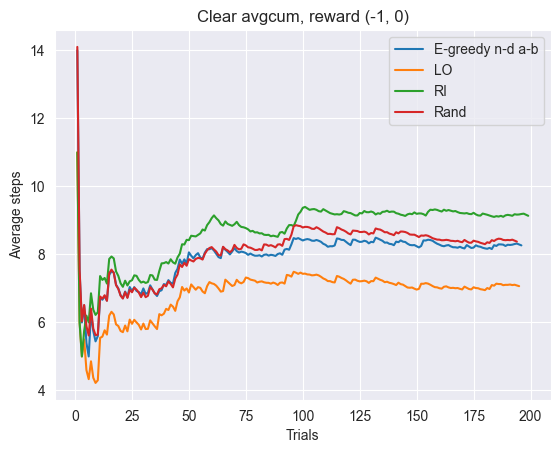

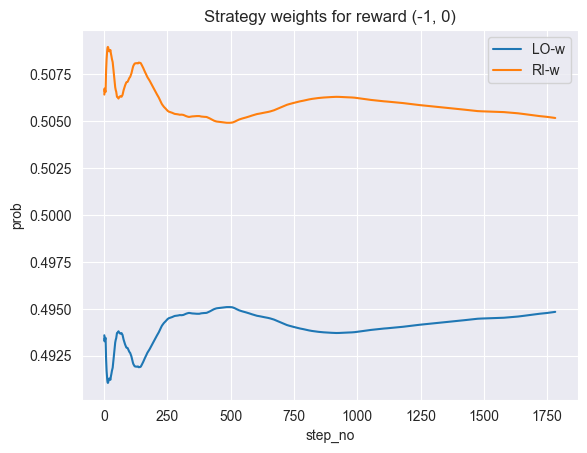

In [6]:
experiment(reward_values=(-1, 0))

# TEST 1

Steps eg orig: [14, 1, 3, 8, 1, 3, 14, 2, 3, 7, 18, 6, 8, 5, 18, 12, 5, 1, 5, 3, 5, 11, 2, 10, 5, 11, 4, 4, 3, 10, 5, 8, 14, 4, 3, 7, 41, 10, 8, 12, 6, 13, 4, 3, 21, 13, 20, 8, 13, 2, 18, 6, 4, 11, 6, 2, 7, 18, 14, 11, 7, 4, 5, 1, 7, 30, 4, 5, 3, 13, 16, 2, 5, 11, 27, 6, 4, 11, 5, 5, 9, 9, 5, 7, 7, 5, 10, 7, 6, 12, 10, 4, 31, 52, 8, 6, 23, 99, 32, 7, 8, 5, 5, 11, 8, 7, 5, 9, 15, 6, 4, 3, 7, 6, 8, 6, 11, 35, 5, 5, 8, 3, 1, 2, 30, 8, 5, 5, 12, 10, 6, 1, 14, 7, 26, 5, 3, 4, 1, 9, 3, 7, 4, 9, 6, 16, 2, 7, 4, 1, 11, 9, 4, 3, 38, 19, 31, 8, 14, 6, 2, 5, 3, 6, 3, 6, 6, 9, 3, 4, 8, 6, 11, 3, 6, 25, 1, 1, 10, 20, 4, 6, 3, 5, 6, 13, 5, 28, 4, 17, 7, 7, 4, 18, 7, 10, 12, 13, 3, 3]


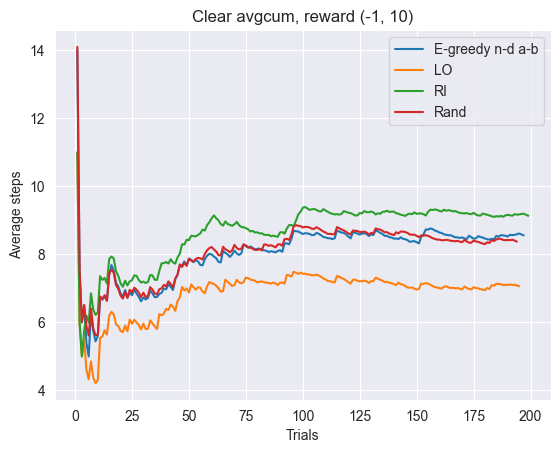

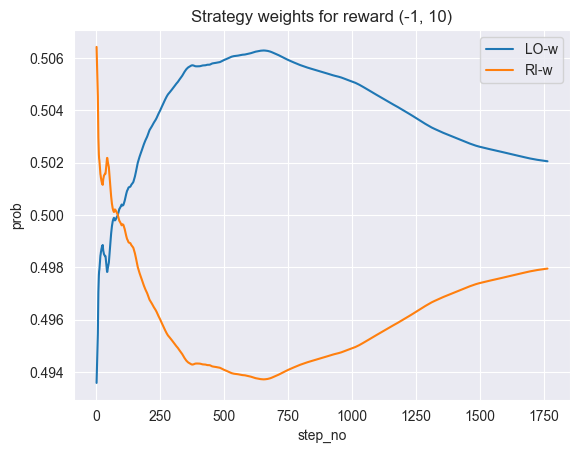

In [7]:
experiment(reward_values=(-1, 10))

Steps eg orig: [14, 1, 3, 8, 1, 3, 14, 2, 3, 7, 18, 6, 8, 5, 18, 10, 7, 1, 5, 3, 5, 10, 4, 14, 3, 10, 7, 4, 3, 12, 1, 6, 14, 3, 3, 4, 38, 9, 8, 8, 6, 13, 4, 2, 21, 13, 20, 3, 19, 3, 24, 5, 4, 14, 8, 1, 6, 21, 14, 6, 8, 4, 5, 2, 7, 30, 4, 8, 3, 14, 17, 2, 5, 10, 13, 6, 4, 9, 4, 6, 9, 14, 5, 9, 7, 6, 10, 7, 4, 11, 10, 4, 25, 51, 9, 6, 23, 99, 24, 10, 6, 5, 6, 11, 6, 7, 5, 8, 13, 5, 5, 5, 4, 3, 10, 8, 9, 37, 6, 6, 7, 2, 3, 2, 17, 8, 3, 5, 9, 11, 6, 1, 14, 7, 27, 5, 9, 4, 7, 9, 3, 6, 5, 21, 6, 16, 3, 7, 3, 1, 8, 9, 8, 3, 54, 16, 37, 8, 12, 7, 3, 6, 5, 6, 3, 6, 12, 9, 3, 4, 8, 7, 12, 3, 6, 25, 1, 2, 7, 20, 3, 6, 2, 5, 6, 12, 5, 31, 4, 16, 6, 7, 3, 18, 7, 9, 4, 11, 3, 3]


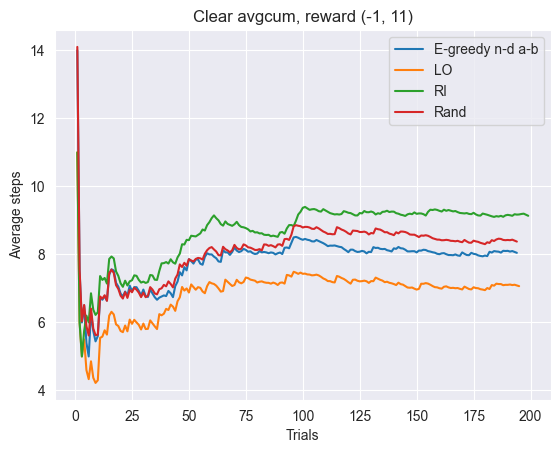

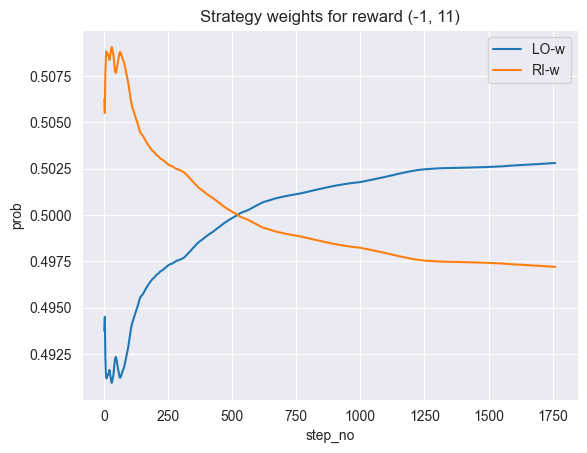

In [8]:
experiment(reward_values=(-1, 11))

# TEST 2
Reward distributions (test_2): 1:1, 1:4, 1:16, 1:32, 1:64, 1:128

Steps eg orig: [14, 1, 3, 8, 1, 3, 14, 2, 3, 7, 18, 6, 8, 5, 18, 14, 7, 1, 5, 3, 5, 12, 4, 10, 3, 11, 6, 4, 2, 12, 1, 8, 14, 4, 3, 5, 49, 8, 8, 8, 6, 13, 4, 1, 21, 13, 20, 4, 17, 1, 24, 4, 6, 13, 11, 1, 7, 18, 14, 9, 7, 4, 5, 1, 6, 30, 4, 8, 3, 14, 24, 2, 5, 11, 17, 6, 4, 7, 6, 7, 8, 9, 5, 12, 9, 5, 10, 7, 4, 11, 10, 4, 25, 52, 11, 6, 23, 99, 24, 8, 9, 11, 5, 9, 8, 7, 5, 9, 12, 5, 3, 5, 7, 2, 9, 8, 9, 32, 7, 4, 6, 5, 1, 8, 26, 8, 3, 5, 10, 12, 6, 1, 14, 7, 26, 5, 7, 4, 1, 9, 3, 6, 4, 27, 5, 16, 1, 9, 1, 1, 9, 8, 4, 3, 54, 13, 38, 8, 12, 7, 5, 2, 2, 4, 3, 6, 9, 9, 2, 4, 8, 7, 15, 3, 6, 25, 1, 1, 10, 20, 3, 6, 2, 5, 6, 12, 3, 30, 4, 17, 5, 7, 1, 13, 7, 10, 5, 15, 3, 3]


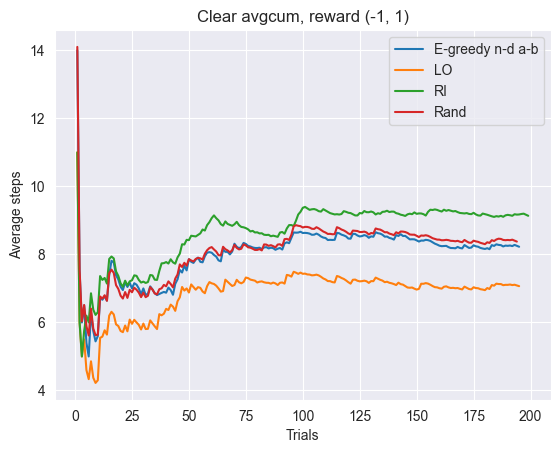

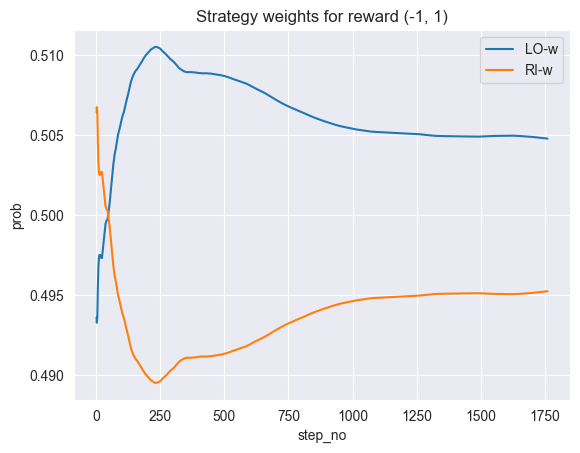

In [9]:
experiment(reward_values=(-1, 1))

Steps eg orig: [14, 1, 3, 8, 1, 3, 14, 2, 3, 7, 18, 6, 8, 5, 18, 9, 7, 1, 5, 3, 5, 10, 4, 10, 8, 10, 5, 7, 5, 13, 3, 7, 14, 5, 3, 4, 45, 16, 8, 9, 6, 13, 4, 6, 21, 13, 20, 2, 11, 1, 24, 7, 8, 12, 10, 1, 4, 21, 14, 12, 7, 4, 2, 2, 8, 27, 3, 4, 3, 14, 20, 2, 5, 11, 19, 6, 4, 11, 6, 4, 7, 11, 5, 15, 7, 5, 10, 7, 8, 11, 10, 4, 31, 49, 8, 5, 23, 99, 30, 15, 6, 5, 5, 10, 5, 7, 5, 8, 18, 6, 3, 4, 7, 6, 10, 7, 11, 38, 7, 3, 5, 4, 5, 2, 27, 8, 6, 5, 12, 11, 6, 1, 14, 7, 26, 5, 4, 4, 3, 9, 3, 7, 5, 23, 4, 16, 2, 7, 3, 1, 11, 8, 3, 3, 40, 16, 33, 8, 12, 6, 3, 2, 4, 4, 3, 6, 6, 9, 4, 5, 8, 6, 15, 4, 6, 25, 1, 1, 8, 20, 3, 6, 3, 5, 6, 13, 3, 30, 4, 18, 5, 7, 2, 20, 7, 10, 12, 13, 3, 3]


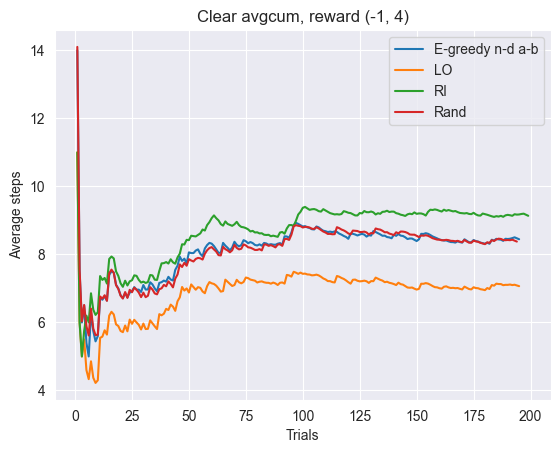

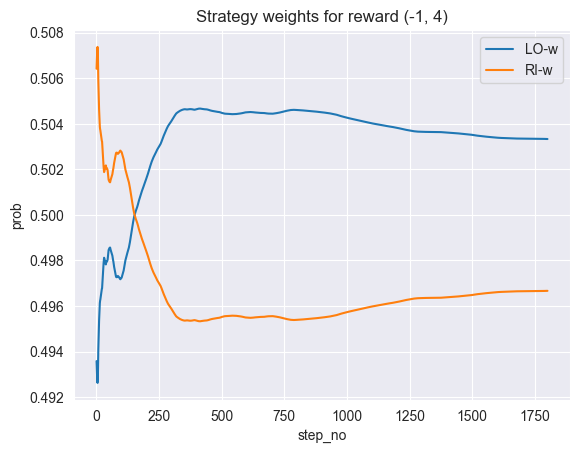

In [10]:
experiment(reward_values=(-1, 4))

Steps eg orig: [14, 1, 3, 8, 1, 3, 14, 2, 3, 7, 18, 6, 8, 5, 18, 10, 7, 1, 5, 3, 5, 10, 4, 14, 4, 10, 6, 4, 2, 12, 1, 7, 14, 3, 3, 5, 43, 6, 8, 8, 6, 13, 4, 3, 21, 13, 20, 4, 13, 2, 21, 4, 5, 14, 6, 3, 9, 21, 14, 7, 6, 4, 2, 2, 8, 27, 4, 6, 3, 12, 20, 2, 5, 11, 11, 6, 4, 12, 4, 4, 9, 10, 5, 9, 7, 6, 10, 7, 7, 19, 10, 4, 31, 49, 11, 6, 23, 99, 17, 13, 9, 5, 5, 8, 8, 7, 5, 8, 16, 5, 4, 3, 7, 6, 12, 4, 9, 29, 7, 3, 8, 4, 1, 9, 32, 8, 5, 5, 12, 12, 6, 1, 15, 7, 26, 4, 13, 4, 3, 9, 3, 5, 4, 19, 6, 16, 1, 5, 1, 3, 11, 9, 3, 3, 51, 14, 40, 8, 13, 7, 2, 1, 5, 4, 3, 6, 6, 9, 6, 4, 8, 6, 10, 5, 5, 25, 1, 1, 5, 20, 3, 6, 4, 5, 6, 13, 4, 31, 4, 16, 5, 7, 1, 12, 7, 10, 10, 15, 3, 3]


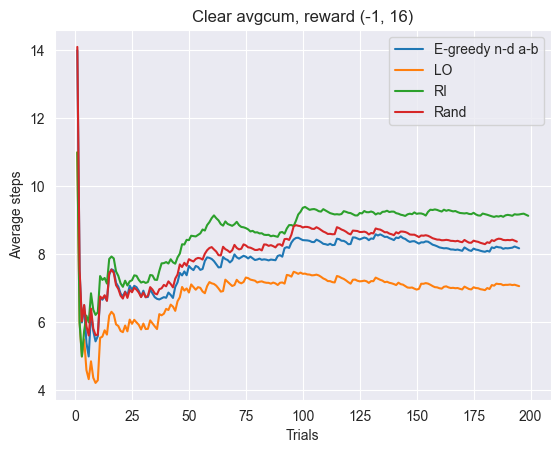

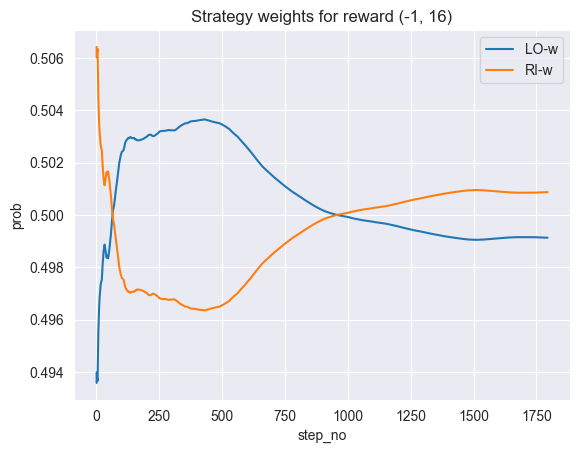

In [11]:
experiment(reward_values=(-1, 16))

Steps eg orig: [14, 1, 3, 8, 1, 3, 14, 2, 3, 7, 18, 6, 8, 5, 18, 13, 7, 1, 5, 3, 5, 12, 2, 18, 4, 10, 7, 6, 4, 13, 1, 6, 14, 5, 3, 4, 34, 8, 8, 15, 6, 13, 4, 2, 21, 13, 20, 6, 13, 1, 18, 8, 4, 11, 8, 1, 7, 23, 14, 10, 6, 4, 4, 1, 6, 26, 4, 10, 5, 14, 20, 2, 5, 8, 13, 6, 4, 13, 4, 3, 6, 10, 5, 9, 7, 5, 10, 7, 4, 12, 10, 4, 28, 51, 9, 6, 23, 99, 28, 12, 9, 5, 5, 11, 6, 7, 5, 9, 17, 6, 5, 5, 7, 2, 7, 8, 11, 40, 7, 4, 8, 5, 2, 2, 26, 8, 3, 5, 11, 12, 6, 1, 14, 7, 29, 6, 5, 4, 1, 9, 3, 7, 4, 23, 4, 16, 1, 7, 1, 3, 7, 10, 3, 3, 44, 13, 36, 8, 14, 6, 5, 1, 3, 4, 3, 6, 6, 9, 4, 5, 8, 6, 10, 5, 6, 25, 1, 1, 9, 20, 3, 6, 4, 5, 6, 12, 2, 34, 4, 17, 7, 7, 1, 21, 7, 10, 7, 12, 3, 3]


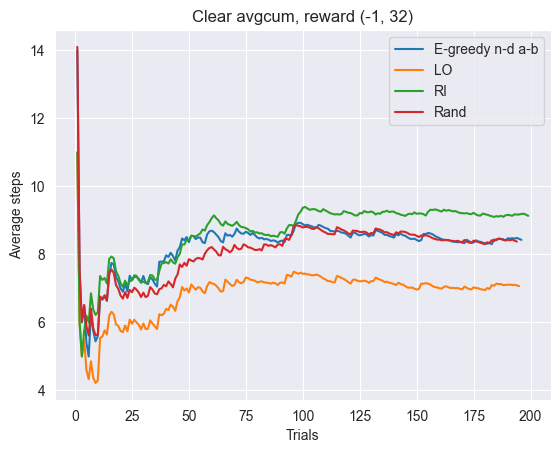

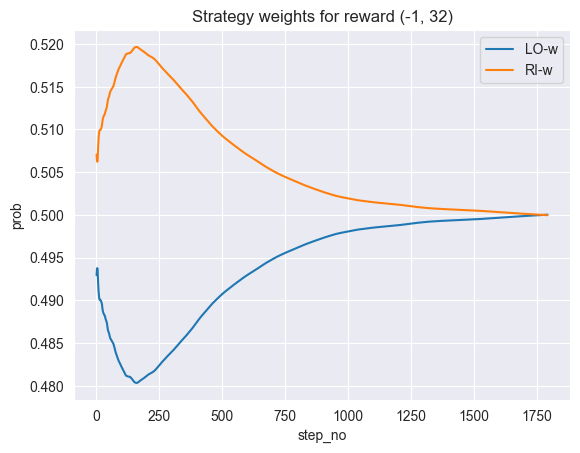

In [12]:
experiment(reward_values=(-1, 32))

Steps eg orig: [14, 1, 3, 8, 1, 3, 14, 2, 3, 7, 18, 6, 8, 5, 18, 9, 7, 1, 5, 3, 5, 12, 2, 18, 4, 11, 4, 4, 3, 8, 1, 7, 16, 3, 3, 7, 36, 7, 8, 8, 6, 13, 4, 2, 21, 13, 20, 3, 19, 2, 24, 6, 4, 11, 11, 5, 7, 20, 14, 15, 7, 4, 3, 2, 6, 27, 4, 5, 4, 13, 14, 2, 5, 11, 21, 6, 4, 9, 6, 3, 8, 9, 5, 17, 9, 5, 10, 7, 4, 13, 10, 4, 28, 52, 12, 6, 23, 99, 28, 9, 8, 5, 4, 9, 6, 7, 5, 9, 13, 6, 5, 2, 7, 7, 10, 6, 11, 37, 5, 4, 8, 2, 2, 7, 36, 8, 3, 5, 11, 10, 6, 1, 15, 7, 26, 5, 5, 4, 1, 9, 3, 7, 4, 17, 4, 16, 1, 7, 1, 2, 9, 9, 5, 3, 42, 9, 29, 8, 12, 7, 5, 3, 4, 6, 3, 5, 6, 9, 4, 5, 8, 6, 12, 4, 6, 25, 1, 4, 10, 20, 3, 6, 3, 5, 6, 13, 3, 25, 4, 16, 11, 7, 2, 16, 7, 10, 6, 11, 3, 3]


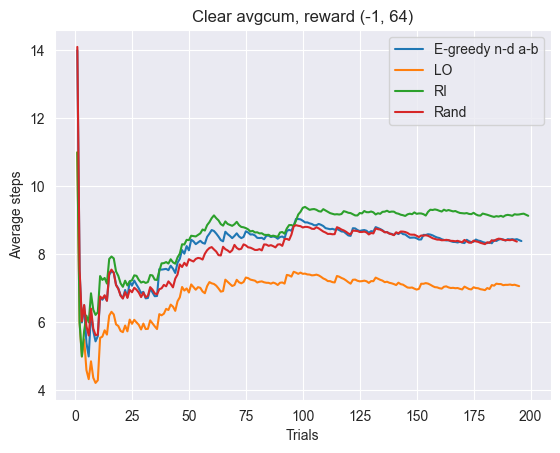

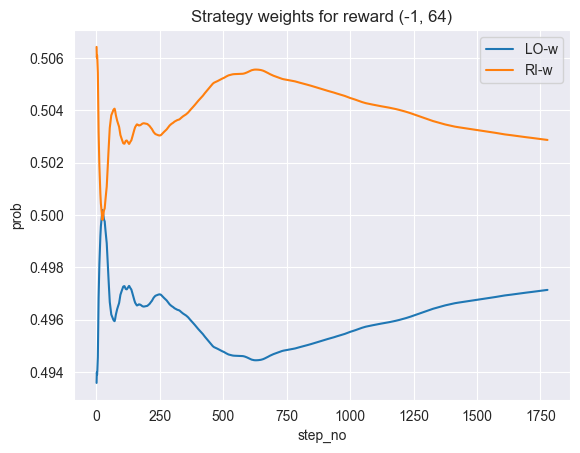

In [13]:
experiment(reward_values=(-1, 64))

Steps eg orig: [14, 1, 3, 8, 1, 3, 14, 2, 3, 7, 18, 6, 8, 5, 18, 9, 7, 1, 5, 3, 5, 10, 4, 18, 3, 10, 5, 4, 4, 12, 1, 9, 14, 5, 3, 7, 40, 9, 8, 15, 6, 13, 4, 1, 21, 13, 20, 3, 15, 4, 15, 5, 4, 13, 11, 1, 6, 21, 14, 6, 6, 4, 2, 2, 7, 29, 4, 7, 4, 14, 24, 2, 5, 11, 15, 6, 4, 12, 5, 4, 8, 9, 5, 12, 7, 6, 10, 7, 3, 11, 10, 4, 31, 51, 13, 6, 23, 99, 28, 8, 12, 5, 4, 10, 10, 7, 5, 9, 14, 5, 5, 3, 7, 5, 10, 5, 11, 43, 6, 6, 8, 5, 1, 4, 28, 8, 3, 5, 9, 12, 6, 1, 15, 7, 26, 6, 9, 4, 1, 9, 3, 7, 4, 26, 6, 16, 1, 7, 2, 3, 10, 9, 5, 3, 59, 16, 39, 8, 12, 7, 5, 1, 2, 4, 3, 6, 13, 9, 4, 5, 8, 6, 13, 3, 6, 25, 1, 1, 8, 20, 5, 6, 2, 5, 6, 12, 3, 23, 4, 16, 6, 7, 2, 16, 7, 10, 6, 12, 3, 3]


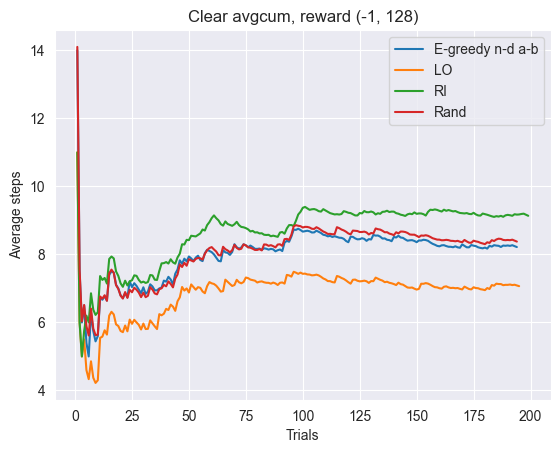

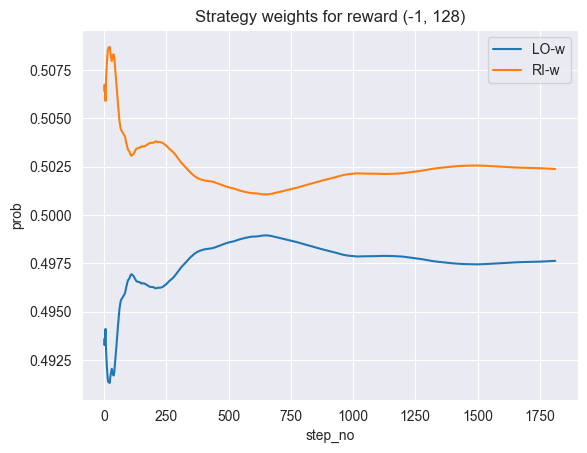

In [14]:
experiment(reward_values=(-1, 128))

In [15]:
reward_values_all = (
    (-1, 0),
    (-1, 1),
    (-1, 2),
    (-1, 4),
    (-1, 8),
    (-1, 9),
    (-1, 10),
    (-1, 11),
    (-1, 12),
    (-1, 16),
    (-1, 32),
    (-1, 64),
    (-1, 100),
    (-1, 128),
)

In [16]:
def experiment_v2(reward_values=(-1, 0)):
    env = LambdaEnv(
        strategies=strategies_env,
        lambda_terms=terms,
        max_step_term=max_count_steps_rlenv,
        count_terms=len(terms),
        reward_values=(-1, 0),
    )

    _, steps_env = run_e_greedy_policy(
        environment=env,
        exploration=explore_actions,
        max_term_reward=max_count_steps_rlenv,
        epsilon=epsilon,
        deterministic=False,
        is_action_based=True,
        return_steps=True,
    )
    wh_env = np.array(env.get_weights_history())

    return steps_env, wh_env


def get_expected_steps(data):
    steps = [x for x in data if x != float("inf")]
    steps = [x for x in steps if x != 0]

    distributions = get_common_distributions()
    distributions.remove("expon")
    distributions.remove("cauchy")
    f = Fitter(steps, distributions=distributions)
    f.fit()

    f_ln = Fitter([np.log(step) for step in steps], distributions=distributions)
    f_ln.fit()
    mu, sigma = f_ln.fitted_param["norm"]
    expected_value = np.e ** (mu + (sigma**2) / 2)

    return expected_value, mu, sigma


def draw_wh(wh_env, reward_values):
    comp_data = {"LO-w": (wh_env[:, 0], "-"), "RI-w": (wh_env[:, 1], "-")}
    draw_mult_lines(
        comp_data,
        title=f"Strategy weights for reward {reward_values}",
        x_label="step_no",
        y_label="prob",
    )

In [17]:
steps_env_all, wh_all = [], []

for rew_values in tqdm(reward_values_all):
    steps_, wh_ = experiment_v2(rew_values)
    steps_env_all.append(steps_)
    wh_all.append(wh_)

100%|██████████| 14/14 [00:20<00:00,  1.44s/it]


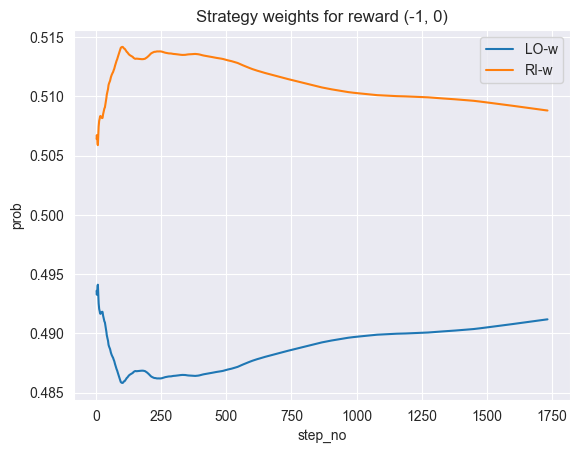

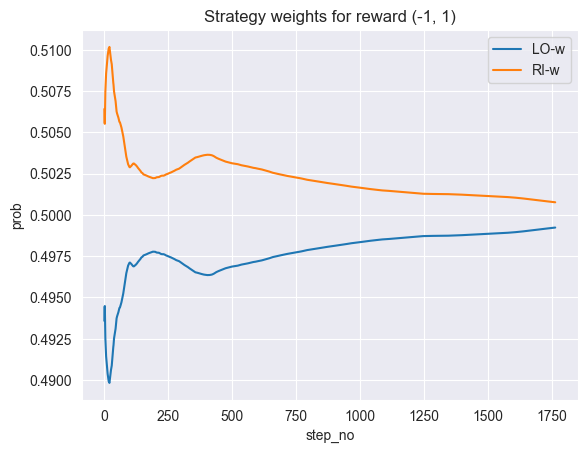

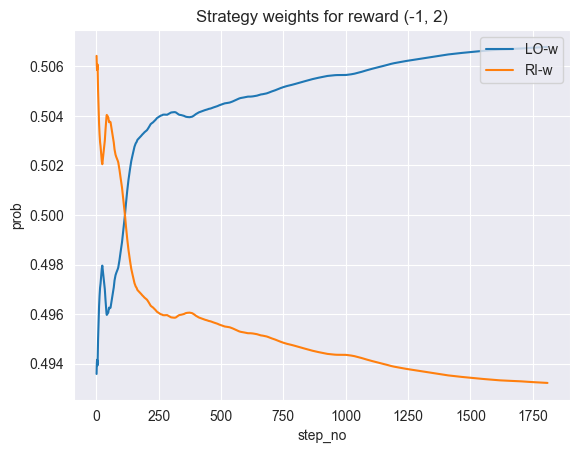

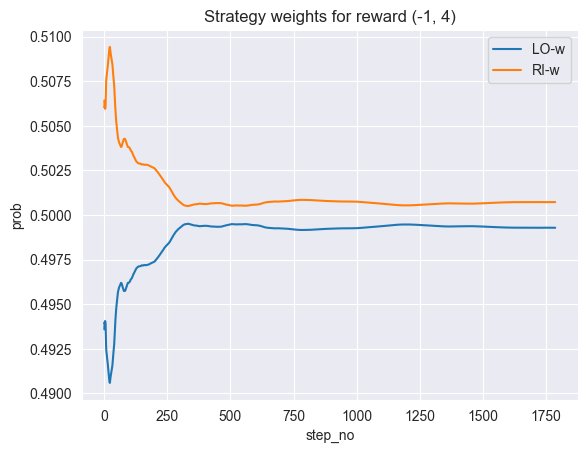

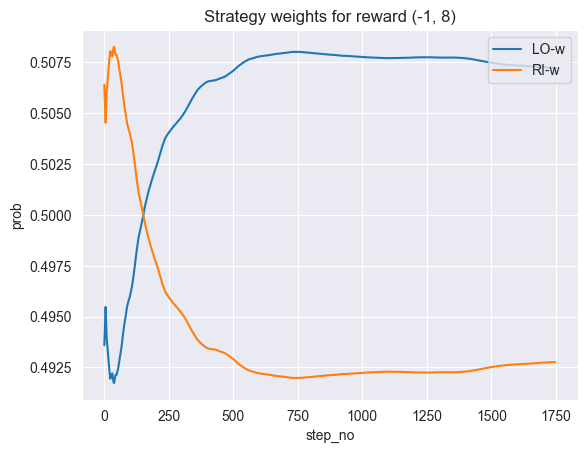

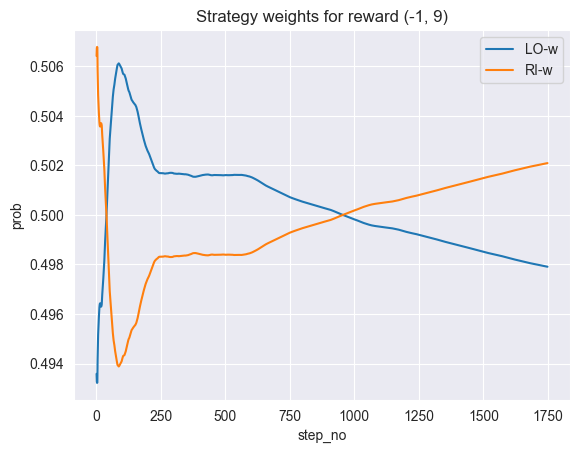

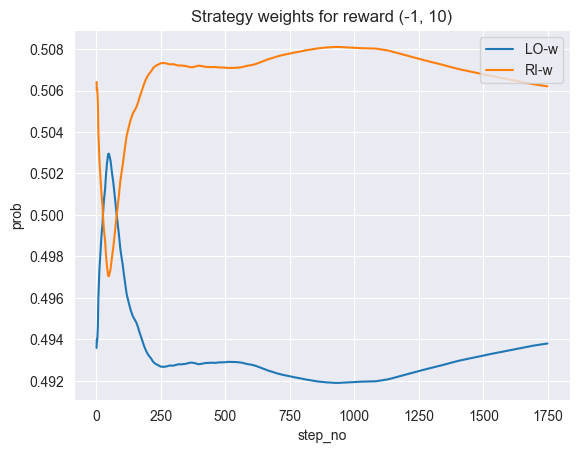

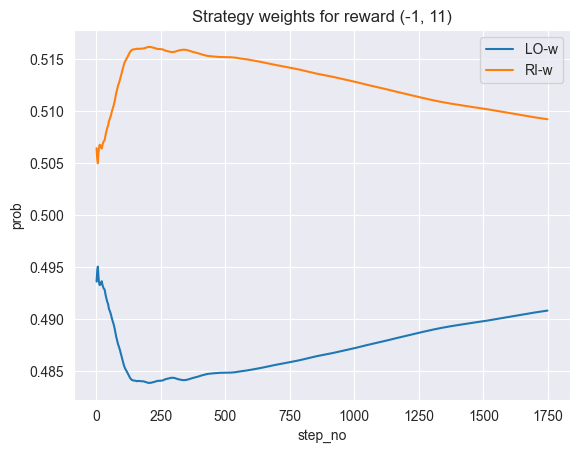

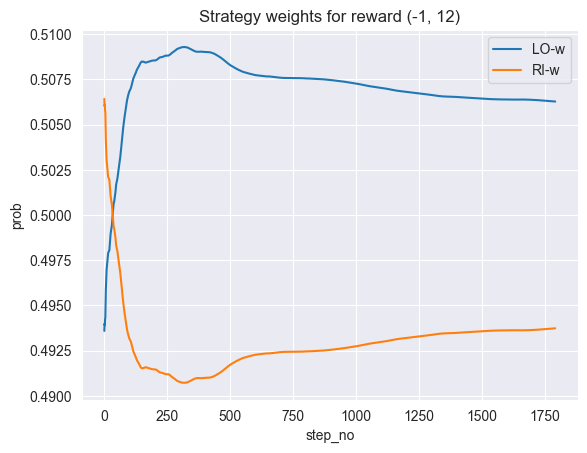

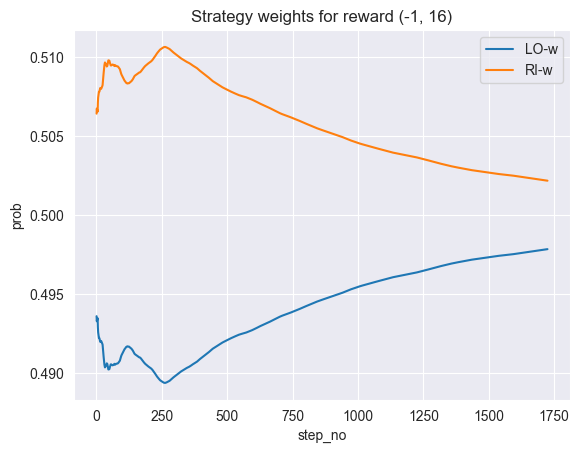

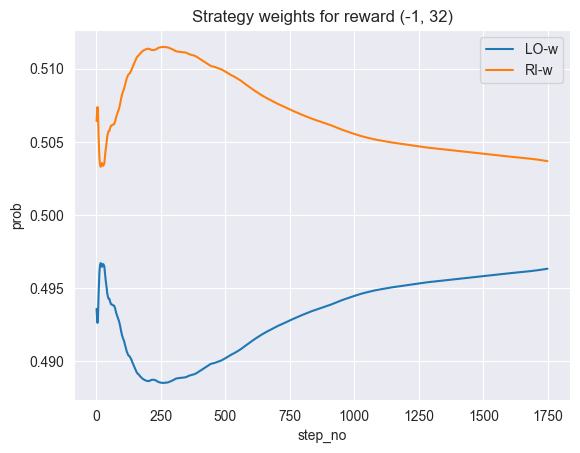

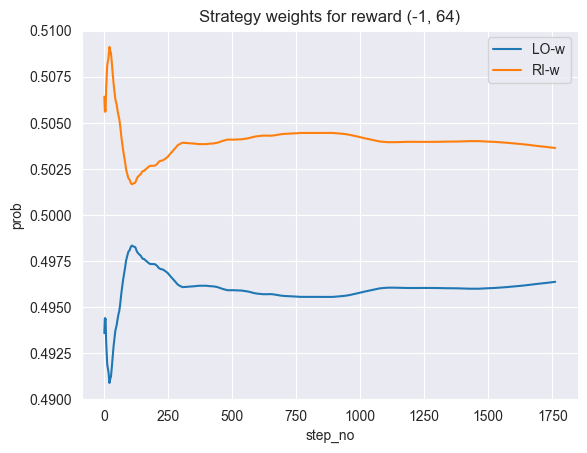

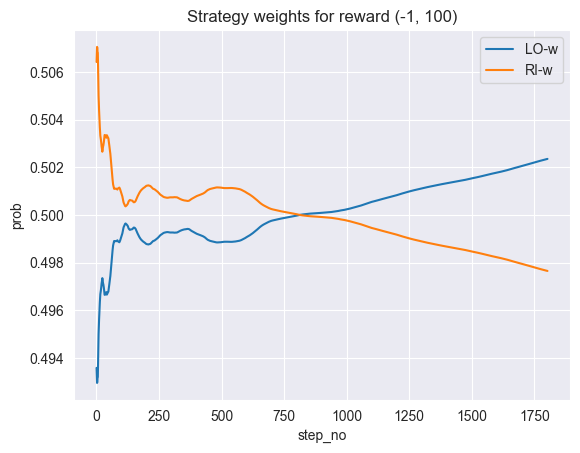

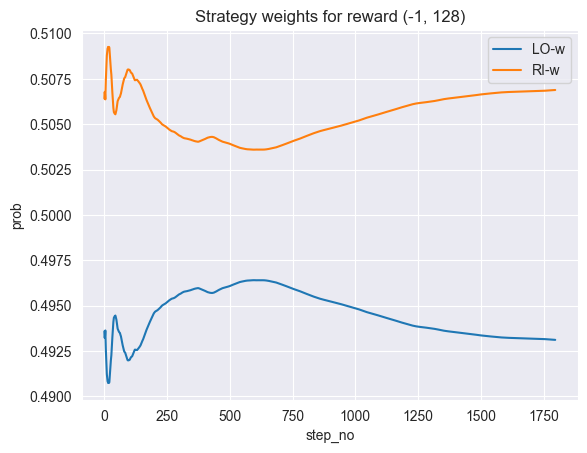

In [18]:
for inx, rew_values in enumerate(reward_values_all):
    draw_wh(wh_env=wh_all[inx], reward_values=rew_values)

In [19]:
expected_value_LO, mu_LO, sigma_LO = get_expected_steps(stepsLO)
expected_value_RI, mu_RI, sigma_RI = get_expected_steps(stepsRI)
expected_value_rand, mu_rand, sigma_rand = get_expected_steps(stepsRand)

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 29.62it/s]


In [20]:
expected_value_all, mu_all, sigma_all = [], [], []
for steps_ in steps_env_all:
    expected_value_, mu_, sigma_ = get_expected_steps(clear_arr(steps_))
    expected_value_all.append(expected_value_)
    mu_all.append(mu_)
    sigma_all.append(sigma_)

Fitting 8 distributions: 100%|██████████| 8/8 [00:00<00:00, 26.15it/s]


In [21]:
print(f"LO Log Norm: mu={mu_LO}, sigma={sigma_LO}; expected value={expected_value_LO}")
print(f"RI Log Norm: mu={mu_RI}, sigma={sigma_RI}; expected value={expected_value_RI}")
print(
    f"Rand Log Norm: mu={mu_rand}, sigma={sigma_rand}; expected value={expected_value_rand}"
)

LO Log Norm: mu=1.678093272663595, sigma=0.9132372555905841; expected value=8.126208171262647
RI Log Norm: mu=2.0555716697869273, sigma=0.6083885967139957; expected value=9.39934505729529
Rand Log Norm: mu=1.967008010113449, sigma=0.7445126247765146; expected value=9.432465679750157


In [22]:
for inx, rew_values in enumerate(reward_values_all):
    print(
        f"{rew_values} Log Norm: mu={mu_all[inx]}, sigma={sigma_all[inx]}; expected value={expected_value_all[inx]}"
    )

(-1, 0) Log Norm: mu=1.8373928369492292, sigma=0.7878068383438165; expected value=8.56524421256256
(-1, 1) Log Norm: mu=1.8389680687952004, sigma=0.8174881889199289; expected value=8.785578218455784
(-1, 2) Log Norm: mu=1.8549729739140965, sigma=0.7973728934034658; expected value=8.783498050151957
(-1, 4) Log Norm: mu=1.8262388894395725, sigma=0.8105594806872682; expected value=8.625666413841873
(-1, 8) Log Norm: mu=1.8085007773266322, sigma=0.7955140999171104; expected value=8.372245423137342
(-1, 9) Log Norm: mu=1.8452264621124774, sigma=0.773159842677487; expected value=8.534480891743282
(-1, 10) Log Norm: mu=1.8257771288546554, sigma=0.7840382560987458; expected value=8.441289846684803
(-1, 11) Log Norm: mu=1.8443559035768446, sigma=0.798518471237973; expected value=8.698684245127575
(-1, 12) Log Norm: mu=1.856571695519959, sigma=0.7665552411359151; expected value=8.588079734452915
(-1, 16) Log Norm: mu=1.8069324837616898, sigma=0.761053440245437; expected value=8.137912139671371
(

In [23]:
inx = expected_value_all.index(min(expected_value_all))
print(
    f"{reward_values_all[inx]} Log Norm: mu={mu_all[inx]}, sigma={sigma_all[inx]}; expected value={expected_value_all[inx]}"
)

(-1, 16) Log Norm: mu=1.8069324837616898, sigma=0.761053440245437; expected value=8.137912139671371
